In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import folium
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from math import cos, asin, sqrt, pi
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

import os
import json
import seaborn
seaborn.set()

def generateBaseMap(default_location=[49.2827 , -123.1207], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

def extractBound(name , json):

    coords = json[0]
    minLat = coords[0][1]
    minLng = coords[0][0]
    maxLat = coords[0][1]
    maxLng = coords[0][0]

    for c in coords:
        if c[1] > maxLat:
            maxLat = c[1]
        if c[1] < minLat:
            minLat = c[1]
        if c[0] > maxLng:
            maxLng = c[0]
        if c[0] < minLng:
            minLng = c[0]
    return (minLat, minLng, maxLat, maxLng)

def withInArea(name , areaBound, latlng):
    minLat = areaBound[0]
    minLng = areaBound[1]
    maxLat = areaBound[2]
    maxLng = areaBound[3]
    
    upLeft = (minLat, maxLng)
    upRight =(maxLat, maxLng)
    downLeft = (minLat , minLng)
    downRight =(maxLat , minLng)
    
    lat = latlng[0]
    lng = latlng[1]
    if lat > upLeft[0] and lng < upLeft[1]  and lat < upRight[0] and lng < upRight[1] and  lat > downLeft[0] and lng > downLeft[1] and lat < downRight[0] and lng > downRight[1]:
        return (name)
    else:
        return
    
def findAreaFromLatLng(df, latlng):
    name = df.apply(lambda x: withInArea(x['Name'] , x['bound'] , latlng) , axis = 1).dropna()
    return name

In [83]:
crime = pd.read_csv('./kaggle/input/crime.csv' ).dropna()
area = pd.read_csv('./kaggle/input/bound.csv', header = 0 , names = [ 'MAPID','Name','Geom','geo_point_2d'] , delimiter = ';')

In [40]:
bounds = area.apply(lambda x: extractBound(x['Name'] , json.loads(x['Geom'])['coordinates']), axis = 1)
area = area.drop(['MAPID' ,'Geom' ,'geo_point_2d'] , axis = 1)
area['bound'] = bounds

crime['date'] = pd.to_datetime({'year':crime['YEAR'], 'month':crime['MONTH'], 'day':crime['DAY']})
crime = crime.drop([ 'HUNDRED_BLOCK' , 'X' , 'Y'] , axis = 1)
crime['dayOfWeek'] = crime['date'].dt.dayofweek

In [41]:
population = pd.read_csv('/Users/sun/Desktop/project/kaggle/input/population.csv',encoding = "ISO-8859-1").dropna()
populationData = [21425 ,13975 , 29325 , 43045 ,7970 , 31065 ,49325 , 32955 ,  13030 , 51530, 36500 , 13065 , 15295, 62030 , 33620 , 29175 , 34575 , 24460 , 22555,8430,12585, 47200]
area['population'] = populationData
area = area.rename(columns ={'Name':'NEIGHBOURHOOD' , 'bound':'bound', 'population':'population'})

In [42]:
crime = crime.join(crime[['YEAR' , 'MONTH' , 'DAY', 'HOUR','TYPE']].groupby(['YEAR' , 'MONTH' , 'DAY', 'HOUR']).count(), on = ['YEAR' , 'MONTH' , 'DAY', 'HOUR'] ,rsuffix='_r')
crime = crime.rename(columns ={'MONTH':'month' , 'DAY':'day', 'HOUR':'hour', 'dayOfWeek':'dayOfWeek','TYPE_r':'num_crimes'})
train = crime.drop(['NEIGHBOURHOOD','date','TYPE','YEAR','MINUTE'],axis = 1)

In [43]:
X = train.drop(['num_crimes'] , axis = 1)
Y = train['num_crimes']
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train , X_valid, Y_train, Y_valid = train_test_split(X,Y)
train_type = crime.drop(['Latitude','Longitude','date','num_crimes','YEAR','MINUTE'],axis = 1)
train_type = train_type.rename(columns ={'MONTH':'month' , 'DAY':'day', 'HOUR':'hour', 'dayOfWeek':'dayOfWeek','TYPE':'type'})

X_type = train_type.drop(['type'] , axis = 1)
Y_type = train_type['type']
X_train_type , X_valid_type, Y_train_type, Y_valid_type = train_test_split(X_type,Y_type)

In [53]:
rf = RandomForestRegressor(n_estimators= 170, max_depth=30, min_samples_leaf=10)

In [54]:
rf.fit(X_train,Y_train)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=170,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [55]:
print("train model score: " , rf.score(X_valid,Y_valid)) 

train model score:  0.7007727767113496


In [56]:

crime


,TYPE,YEAR,month,day,hour,MINUTE,NEIGHBOURHOOD,Latitude,Longitude,date,dayOfWeek,num_crimes
0,Other Theft,2003,5,12,16.0,15.0,Strathcona,49.269802,-123.083763,2003-05-12,0,7
1,Other Theft,2003,5,7,15.0,20.0,Strathcona,49.269802,-123.083763,2003-05-07,2,2
2,Other Theft,2003,4,23,16.0,40.0,Strathcona,49.269802,-123.083763,2003-04-23,2,8
3,Other Theft,2003,4,20,11.0,15.0,Strathcona,49.269802,-123.083763,2003-04-20,6,2
4,Other Theft,2003,4,12,17.0,45.0,Strathcona,49.269802,-123.083763,2003-04-12,5,11
5,Other Theft,2003,3,26,20.0,45.0,Strathcona,49.269802,-123.083763,2003-03-26,2,8
6,Break and Enter Residential/Other,2003,3,10,12.0,0.0,Kerrisdale,49.228051,-123.146610,2003-03-10,0,6
7,Mischief,2003,6,28,4.0,13.0,Dunbar-Southlands,49.255559,-123.193725,2003-06-28,5,3
8,Other Theft,2003,2,16,9.0,2.0,Strathcona,49.269802,-123.083763,2003-02-16,6,4
9,Break and Enter Residential/Other,2003,7,9,18.0,15.0,Grandview-Woodland,49.267734,-123.067654,2003-07-09,2,10


In [71]:
a = crime
crime_regress = crime
ts  = a.date.values.astype(np.int64) 

In [72]:
fit = stats.linregress(crime_ts ,a['num_crimes'])
prediction = crime_ts*fit.slope + fit.intercept

-5.041178139930897e-18

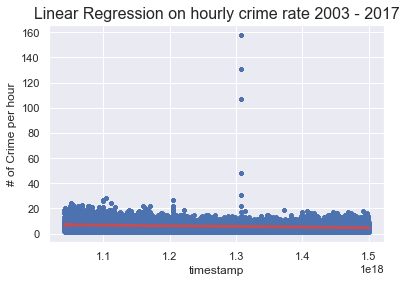

In [73]:
plt.title('Linear Regression on hourly crime rate 2003 - 2017', fontsize=16)
plt.plot(ts,crime_regress['num_crimes'],'b.',alpha=0.5)
plt.plot(ts ,prediction, 'r' ,linewidth=3)
plt.xlabel('timestamp')
plt.ylabel('# of Crime per hour')
fit.slope

In [78]:
fit.pvalue

0.0

In [79]:
crime_other = crime[crime['TYPE'] == 'Other Theft']
crime_vehicle = crime[crime['TYPE'] == 'Theft from Vehicle']
crime_breakIn = crime[crime['TYPE'] == 'Break and Enter Residential/Other']

Text(0, 0.5, '# of Crime')

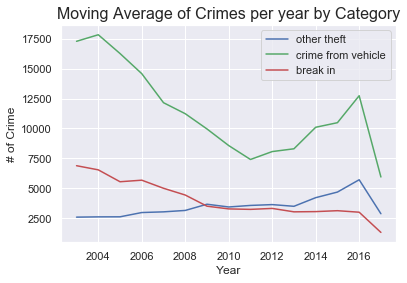

In [80]:
plt.title('Moving Average of Crimes per year by Category', fontsize=16)

crime_other = crime_other.groupby(['YEAR']).count()
type = crime_other['TYPE']
year = crime_other.groupby(['YEAR']).count().reset_index()['YEAR']
plt.plot(year, type, 'b-' , label = 'other theft')

crime_vehicle = crime_vehicle.groupby(['YEAR']).count()
type = crime_vehicle['TYPE']
year = crime_vehicle.groupby(['YEAR']).count().reset_index()['YEAR']
plt.plot(year, type, 'g-',label='crime from vehicle')

crime_breakIn = crime_breakIn.groupby(['YEAR']).count()
type = crime_breakIn['TYPE']
year = crime_breakIn.groupby(['YEAR']).count().reset_index()['YEAR']
plt.plot(year, type, 'r-',label='break in')
plt.legend()
plt.xlabel('Year')
plt.ylabel('# of Crime')

